In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [2]:
df_news = pd.read_csv("../data/news_apple_2022.csv", index_col=0)
df_price = pd.read_csv("../data/price_apple_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:32:44  I actually lost weight this holiday season — t...
1 2022-01-01 00:52:34  January Dogs Of The Dow Need A PullbackThirty-...
2 2022-01-01 01:04:02  I switched from Android to iPhone — here's wha...
3 2022-01-01 01:36:26  365 Inspirational Quotes for 2022Inspiring, po...
4 2022-01-01 02:06:21  Is Fitbit Premium worth it? Here's the pros an...
                 date       price
0 2022-01-03 09:31:00  175.826576
1 2022-01-03 09:32:00  176.596792
2 2022-01-03 09:33:00  176.636290
3 2022-01-03 09:34:00  176.776509
4 2022-01-03 09:35:00  176.705412


In [3]:
df_score = pd.read_csv("../data/news_score_apple_2022_4.csv", index_col=0)
df_score = df_score[["date", "score"]]
df_score["date"] = pd.to_datetime(df_score['date'])

In [4]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [5]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [6]:
df_news.shape

(43832, 2)

In [7]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [8]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [9]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
113,2022-01-03 09:39:53,Apple's wearable gadget business grew like gan...,178.068103,1.0,0.001497,-0.002163,0.004714,0.003161
123,2022-01-03 10:22:45,Water Ways Technologies Strengthens its Board ...,178.349528,1.0,0.001966,0.001301,0.002575,0.002962
133,2022-01-03 11:14:35,OPEC+ Set to Boost Supply Again With Oil Marke...,178.551957,1.0,0.000774,0.002876,0.003650,0.002599
143,2022-01-03 11:45:53,Apple's Series 7 Watch Drops to Its Lowest Pri...,179.253051,1.0,0.000220,0.000413,-0.000992,0.002589
153,2022-01-03 12:51:41,Most Active Equity Options For Midday - Monday...,179.687532,0.0,-0.000769,-0.001374,0.000879,0.003242
...,...,...,...,...,...,...,...,...
31893,2022-09-22 10:05:39,2 Monster Stocks to Buy Without Any Hesitation...,151.200407,1.0,0.000656,0.002558,0.000131,-0.005640
31903,2022-09-22 11:14:30,Saoirse Ronan To Star In Steve McQueen's 'Blit...,150.184076,1.0,-0.001287,-0.002872,0.002278,0.001419
31913,2022-09-22 12:34:34,Tom Russo on His Investing Strategy and Lesson...,150.669932,1.0,0.002534,0.002534,0.002402,0.004672
31923,2022-09-22 13:53:35,Film Exec Emily Wolfe Joins Plan B Entertainme...,151.557363,1.0,-0.001178,-0.002126,-0.005430,-0.000458


In [10]:
result_df = result_df.dropna()

In [11]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_24427/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,1041,1041,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
unique,1041,1036,986.000000,NaN,NaN,NaN,NaN,NaN
top,2022-01-03 09:39:53,DesignCon Makes a Strong Return to Santa Clara...,164.986872,NaN,NaN,NaN,NaN,NaN
freq,1,2,3.000000,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 09:39:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-09-22 14:52:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.521614,0.000034,0.000037,0.000113,-0.000091
std,NaN,NaN,NaN,0.746636,0.001988,0.002749,0.004571,0.006231
min,NaN,NaN,NaN,-1.000000,-0.012320,-0.018673,-0.022671,-0.028552
25%,NaN,NaN,NaN,0.000000,-0.000971,-0.001467,-0.002465,-0.003420


In [12]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [13]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [14]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,-0.022953,0.021178,-0.023403,-0.042625
return_in5,-0.022953,1.000000,0.718970,0.414583,0.348337
return_in10,0.021178,0.718970,1.000000,0.576958,0.423558
return_in20,-0.023403,0.414583,0.576958,1.000000,0.709226
return_in60,-0.042625,0.348337,0.423558,0.709226,1.000000


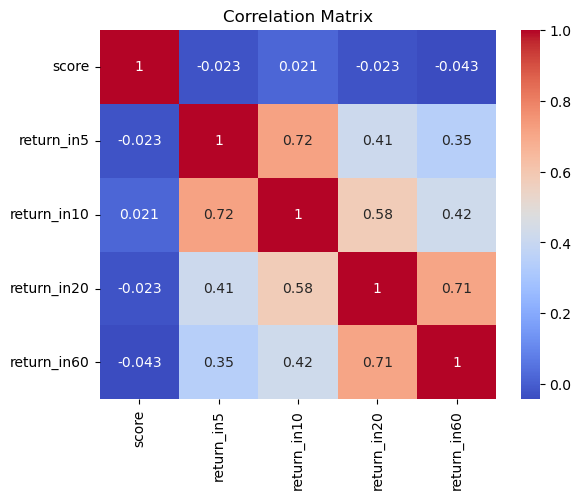

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=df)
    plt.title(f'Score vs {return_col}')
    plt.show()

NameError: name 'df' is not defined

In [ ]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(1295, 4)

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [ ]:
lr.coef_

array([[ 2.49438278e-05],
       [-1.45494302e-05],
       [-7.75785446e-05],
       [-8.88627389e-05]])